In [1]:
from Formula import Formula
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

1.0


In [2]:
class InitialConfigurations:
    @staticmethod
    def uniform(num_agents):
        belief_array = np.array([i/(num_agents - 1)
                                for i in range(num_agents)])
        belief_array[0] = 0
        belief_array[-1] = 1 - 0
        return belief_array

    def mildly(num_agents):
        middle = np.ceil(num_agents / 2)
        return [0.2 + 0.2 * i / middle if i < middle else 0.6 + 0.2 * (i - middle) / (num_agents - middle) for i in range(num_agents)]

    def extreme(num_agents):
        middle = np.ceil(num_agents / 2)
        belief_array = np.array([0.2 * i / middle if i < middle else 0.8 + 0.2 * (
            i - middle) / (num_agents - middle) for i in range(num_agents)])
        belief_array[0] = 0
        return belief_array

    def tripolar(num_agents):
        beliefs = [0.0] * num_agents
        first_third = num_agents // 3
        middle_third = np.ceil(num_agents * 2 / 3) - first_third
        last_third = num_agents - middle_third - first_third
        offset = 0
        for i, segment in enumerate((first_third, middle_third, last_third)):
            for j in range(int(segment)):
                beliefs[int(j+offset)] = 0.2 * j / segment + (0.4 * i)
            offset += segment
        beliefs[0] = 0
        return np.array(beliefs)

In [3]:
class InfluenceGraphs:
    def clique(num_agents: int, influence: float):
        influence_graph = np.full((num_agents, num_agents), influence)
        for i in range(num_agents):
            influence_graph[i, i] = 1
        return influence_graph

    def circular(num_agents: int, influence: float):
        inf_graph = np.zeros((num_agents, num_agents))
        for i in range(num_agents):
            inf_graph[i, i] = 1.0
            inf_graph[i, (i + 1) % num_agents] = influence
        return inf_graph

    def disconnected(num_agents: int, influence: float):
        inf_graph = np.zeros((num_agents, num_agents))
        middle = int(np.ceil(num_agents / 2))
        inf_graph[:middle, :middle] = influence
        inf_graph[middle:, middle:] = influence
        for i in range(num_agents):
            inf_graph[i, i] = 1
        return inf_graph

    def faintly(num_agents: int, weak_influence: float, strong_influence: float):
        inf_graph = np.full((num_agents, num_agents), weak_influence)
        middle = int(np.ceil(num_agents / 2))
        inf_graph[:middle, :middle] = strong_influence
        inf_graph[middle:, middle:] = strong_influence
        for i in range(num_agents):
            inf_graph[i, i] = 1
        return inf_graph

    def two_influencers_balanced(num_agents, influencers_incoming_value, influencers_outgoing_value, others_belief_value):
        inf_graph = np.full((num_agents, num_agents), others_belief_value)
        inf_graph[0, :-1] = influencers_outgoing_value
        inf_graph[-1, 1:] = influencers_outgoing_value
        inf_graph[1:, 0] = influencers_incoming_value
        inf_graph[:-1, -1] = influencers_incoming_value
        for i in range(num_agents):
            inf_graph[i, i] = 1
        return inf_graph

    def two_influencers_unbalanced(num_agents, influencers_outgoing_value_first, influencers_outgoing_value_second, influencers_incoming_value_first, influencers_incoming_value_second, others_belief_value):
        inf_graph = np.full((num_agents, num_agents), others_belief_value)
        inf_graph[0, :-1] = influencers_outgoing_value_first
        inf_graph[-1, 1:] = influencers_outgoing_value_second
        inf_graph[1:, 0] = influencers_incoming_value_first
        inf_graph[:-1, -1] = influencers_incoming_value_second
        for i in range(num_agents):
            inf_graph[i, i] = 1
        return inf_graph

In [4]:
NUM_AGENTS = 10
WEAK_INFLUENCE = 0.1
STRONG_INFLUENCE = 0.5
influence_graph = InfluenceGraphs.faintly(num_agents=NUM_AGENTS, weak_influence=0.1, strong_influence=0.5)
state = InitialConfigurations.mildly(num_agents=NUM_AGENTS)

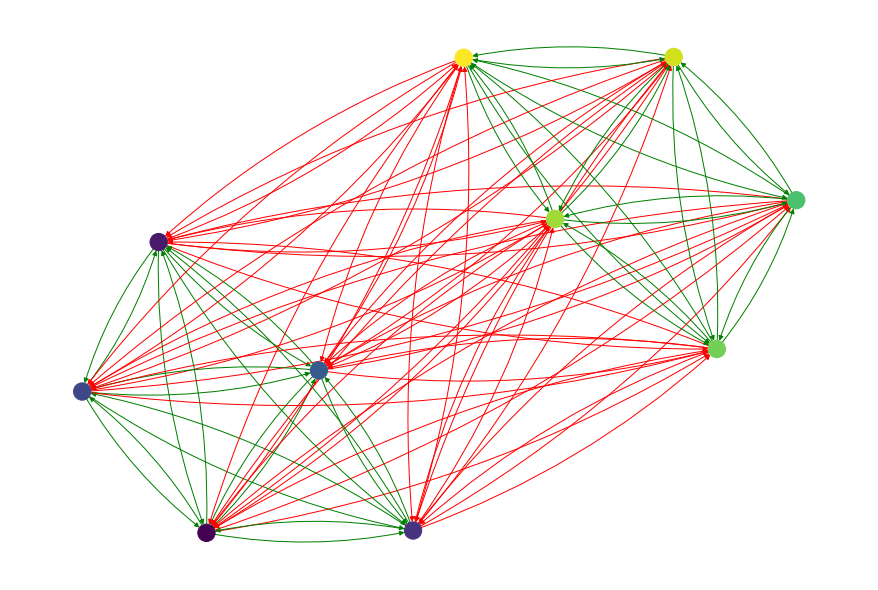

In [13]:
G = nx.DiGraph()

for i in range(NUM_AGENTS):
    G.add_node(i, weight=state[i])

for i in range(NUM_AGENTS):
    for j in range(NUM_AGENTS):
        if i != j:
            weight = influence_graph[j][i]
            color = 'r' if influence_graph[j][i] == 0.1 else 'g'
            G.add_edge(j, i, weight=weight, color=color)

# labels = {n: f'{round(G.nodes[n]["weight"], 2)}' for n in G.nodes}
node_colors = [G.nodes[n]['weight'] for n in G.nodes]
# weight_colors = [G[u][v]['weight'] for u,v in G.edges]

edges = G.edges()
edge_colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

plt.figure(1, figsize=(12,8)) 
# nx.draw_circular(G, with_labels=True, labels=labels, node_color=colors)
nx.draw(G, node_color=node_colors, edge_color=edge_colors, connectionstyle="arc3,rad=0.1")
plt.show()

In [20]:
def graph_state_to_frame(influence_graph, state):
    return {
        "p": {i: state[i] for i in range(len(state))},
        "relation": {
            i: {
                j: influence_graph[i][j]
                for j in range(len(influence_graph[i]))
                if i != j
            }
            for i in range(len(influence_graph))
        },
    }

In [24]:
agent = 2
frame = graph_state_to_frame(influence_graph, state)

In [26]:
state

[0.2,
 0.24000000000000002,
 0.28,
 0.32000000000000006,
 0.36,
 0.6,
 0.64,
 0.6799999999999999,
 0.72,
 0.76]

In [22]:
formula = Formula("[] p")
[round(formula.evaluate(frame, agent), 2) for agent in range(NUM_AGENTS)]

[0.24, 0.2, 0.2, 0.2, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0]

In [23]:
formula = Formula("<> p")
[round(formula.evaluate(frame, agent), 2) for agent in range(NUM_AGENTS)]

[0.36, 0.36, 0.36, 0.36, 0.32, 0.5, 0.5, 0.5, 0.5, 0.5]

In [11]:
# TODO Verify why it is 0.24 at [] p e 0.32 and <> p
# TODO Not symmetric problem